# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [18]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from __future__ import division

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [9]:
def P1(num_examples=5):
    for i in range(num_examples):
        print '%s:\n%s\n' %(categories[train_labels[i]], train_data[i])
P1()

talk.religion.misc:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

sci.space:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

comp.graphics:

 >In article

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [58]:
def P2():
    cv = CountVectorizer()
    corpus = cv.fit_transform(train_data)
    print ('The data has a vocabulary %d words') %corpus.shape[1]
    print ('Each example has an average of %.1f non-zero features') %(corpus.nnz/corpus.shape[0])
    print ('The first and last feature strings are \'%s\' and \'%s\' respectively') \
                        %(cv.get_feature_names()[0], cv.get_feature_names()[-1])
    
    custom_vocab = ['atheism','graphics','space','religion']
    cv = CountVectorizer(vocabulary=custom_vocab)
    corpus = cv.fit_transform(train_data)
    print ('\nUsing a custom vocabulary the data has a vocabulary %d words') %corpus.shape[1]
    print ('Using a custom vocabulary each example has an average of %.1f non-zero features') %(corpus.nnz/corpus.shape[0])
    
    cv = CountVectorizer(analyzer='char', ngram_range=[2,3])
    corpus = cv.fit_transform(train_data)
    print ('\nUsing character bigrams and ngrams the data has a vocabulary %d words') %corpus.shape[1]
    print ('Using character bigrams and ngrams each example has an average of %.1f non-zero features') %(corpus.nnz/corpus.shape[0])
    
    cv = CountVectorizer(min_df=10)
    corpus = cv.fit_transform(train_data)
    print ('\nPruning our vocabulary reduce our feature size to %d words') %corpus.shape[1]
    
    cv = CountVectorizer()
    cv.fit_transform(train_data)

    cvd = CountVectorizer()
    cvd.fit(dev_data)

    new_words = set(cvd.get_feature_names()) - set(cv.get_feature_names())
    print ('\n%.1f%% of words in our dev data are not seen in the training data') %(len(new_words) / len(cvd.get_feature_names()) * 100)
    
    
P2()

The data has a vocabulary 26879 words
Each example has an average of 96.7 non-zero features
The first and last feature strings are '00' and 'zyxel' respectively

Using a custom vocabulary the data has a vocabulary 4 words
Using a custom vocabulary each example has an average of 0.3 non-zero features

Using character bigrams and ngrams the data has a vocabulary 35478 words
Using character bigrams and ngrams each example has an average of 684.2 non-zero features

Pruning our vocabulary reduce our feature size to 3064 words
24.8% of words in our dev data are not seen in the training data


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [4]:
#def P3():
### STUDENT START ###

### STUDENT END ###
#P3()

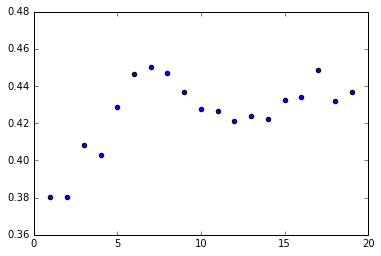

In [525]:
scores = []
for k in range(1,20):
    cv = CountVectorizer()
    train_corpus = cv.fit_transform(train_data)
    dev_corpus = cv.transform(dev_data)

    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(train_corpus, train_labels)
    pred = clf.predict(dev_corpus)

    scores.append(metrics.f1_score(dev_labels, pred, average='weighted'))
    
ax1 = plt.scatter(range(1,20), scores)


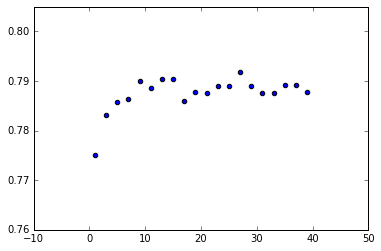

In [526]:
scores = []
params = range(1,40,2)

for k in params:
    cv = CountVectorizer()
    train_corpus = cv.fit_transform(train_data)
    dev_corpus = cv.transform(dev_data)

    clf = MultinomialNB(alpha=k/100)
    clf.fit(train_corpus, train_labels)
    pred = clf.predict(dev_corpus)

    scores.append(metrics.f1_score(dev_labels, pred, average='weighted'))
    
ax1 = plt.scatter(params, scores)

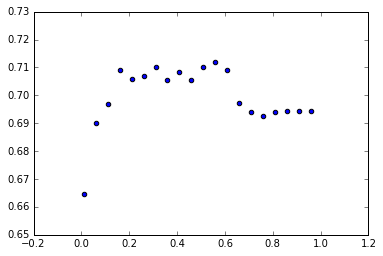

In [318]:
scores = []
params = np.array(range(1,100,5))

for k in params:
    cv = CountVectorizer()
    train_corpus = cv.fit_transform(train_data)
    dev_corpus = cv.transform(dev_data)

    clf = LogisticRegression(C=k/100)
    clf.fit(train_corpus, train_labels)
    pred = clf.predict(dev_corpus)

    scores.append(metrics.f1_score(dev_labels, pred, average='weighted'))
    

plt.title('')
plt.xlabel('')
plt.ylabel('')
ax = plt.scatter(params/100, scores)

ANSWER: KNN would not work well because it involves drawing decision boundaries between different labels. Texts share a lot of similar words, especially if stop words are not removed. So with document classification, what we're really looking for a few features that differentiate topics from each other, even if they share a lot of other similar words. This makes drawing a decision boundary difficult when there is so much overlap.

Naive Bayes works better in this case because of our lack of data. Naive Bayes assume conditional independence between all of the words while logistic regression tries to fit all features at the same time. While assuming conditional independence is a simplification, it makes it much easier to find optimal weights when we have a lack of data. In the long run, I would expect LR to outperformance NB.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [417]:
def print_top_coefs(coef_matrix, features, train_headers, num_features):
    sort_index = np.argsort(coef_matrix,)[:,::-1][:,:num_features]

    for index, label in enumerate(sort_index):
        print '{:20s} |  {:>15s} {:>15s} {:>15s} {:>20s}'.format(
            train_headers[index], train_headers[0], train_headers[1], train_headers[2], train_headers[3])
        print '-' * 95

        for i in label:
            coefs = []
            coefs.append(features[i])
            coefs += list(coef_matrix[:,i])
            print '{:20s} |  {:15.2f} {:15.2f} {:15.2f} {:20.2f}'.format(
                coefs[0], coefs[1], coefs[2], coefs[3], coefs[4])
        print '\n'

In [423]:
def P4():
    cv = CountVectorizer()
    train_corpus = cv.fit_transform(train_data)

    clf = LogisticRegression(C=0.6)
    clf.fit(train_corpus, train_labels)
    
    print 'Unigram Features:\n'
    print_top_coefs(clf.coef_, cv.get_feature_names(), newsgroups_train.target_names, 5)

    cv_ngram = CountVectorizer(ngram_range=[2,2])
    train_corpus_ngram = cv_ngram.fit_transform(train_data)

    clf_ngram = LogisticRegression(C=0.7)
    clf_ngram.fit(train_corpus_ngram, train_labels)
    
    print 'Bigram Features:\n'
    print_top_coefs(clf_ngram.coef_, cv_ngram.get_feature_names(), newsgroups_train.target_names, 5)
    

P4()

Unigram Features:

alt.atheism          |      alt.atheism   comp.graphics       sci.space   talk.religion.misc
-----------------------------------------------------------------------------------------------
atheists             |             0.88           -0.09           -0.28                -0.69
bobby                |             0.87           -0.20           -0.30                -0.41
religion             |             0.84           -0.54           -0.69                -0.06
atheism              |             0.83           -0.37           -0.39                -0.39
deletion             |             0.81           -0.28           -0.31                -0.30


comp.graphics        |      alt.atheism   comp.graphics       sci.space   talk.religion.misc
-----------------------------------------------------------------------------------------------
graphics             |            -0.67            1.71           -1.16                -0.66
image                |            -0.50    

ANSWER: I find the top bigram features to be interesting. Particularly, the 'cheers kent' bigram which is likely indicative of a frequent author rather than actual content related. Overall, the bigrams seem to be much less reliable as features that would be generalizable to a test set. A lot of the features involve common phrases such as 'look up', 'was just', 'it was', likely because of the rarity of more content-relevant bigrams.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [546]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    s = re.sub('[\.,\,,\',\?,\!\"]', '', s) # remove punctuation
    s = re.sub('[0-9]+\.*[0-9]*[a-z]*', '', s) # remove all numbers
    s = re.sub('_+','',s) # remove underscores
    s = s.lower()
    s = re.sub('(s|ly|ing|ian)\\b', '', s)  # some basic stemming
    return s

def P5():
    cv = CountVectorizer(stop_words='english', preprocessor=empty_preprocessor)
    train_corpus = cv.fit_transform(train_data)
    dev_corpus = cv.transform(dev_data)
    empty_dict = len(cv.get_feature_names())

    clf = LogisticRegression(C=0.7)
    clf.fit(train_corpus, train_labels)
    print ('F1 score with empty preprocessor: %.3f') %clf.score(dev_corpus, dev_labels)
    preds = clf.predict(dev_corpus)
    print classification_report(dev_labels, preds, target_names=newsgroups_train.target_names)
    
    cv = CountVectorizer(stop_words='english', preprocessor=better_preprocessor)
    train_corpus = cv.fit_transform(train_data)
    dev_corpus = cv.transform(dev_data)
    better_dict = len(cv.get_feature_names())
    
    clf = LogisticRegression(C=0.7)
    clf.fit(train_corpus, train_labels)
    print ('F1 score with better preprocessor: %.3f') %clf.score(dev_corpus, dev_labels)
    preds = clf.predict(dev_corpus)
    print classification_report(dev_labels, preds, target_names=newsgroups_train.target_names)
    
    print ('Using my better preprocessor, I reduced the dictionary size by %d%% from %s to %s') \
                %((1 - better_dict / empty_dict) * 100, empty_dict, better_dict)
        
P5()

F1 score with empty preprocessor: 0.717
                    precision    recall  f1-score   support

       alt.atheism       0.61      0.55      0.58       165
     comp.graphics       0.86      0.87      0.87       185
         sci.space       0.74      0.85      0.79       199
talk.religion.misc       0.58      0.50      0.54       127

       avg / total       0.71      0.72      0.71       676

F1 score with better preprocessor: 0.740
                    precision    recall  f1-score   support

       alt.atheism       0.67      0.59      0.63       165
     comp.graphics       0.85      0.89      0.87       185
         sci.space       0.75      0.85      0.80       199
talk.religion.misc       0.63      0.54      0.58       127

       avg / total       0.73      0.74      0.73       676

Using my better preprocessor, I reduced the dictionary size by 37% from 32994 to 20666


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

In [440]:
# def P6():
num_features = []
accuracies = []

for reg_strength in [0.01, 0.02, 0.04, 0.05, 0.1, 1, 2, 5]:
    cv = CountVectorizer()
    train_corpus = cv.fit_transform(train_data)

    clf = LogisticRegression(penalty='l1', C=reg_strength)
    clf.fit(train_corpus, train_labels)

    features = np.argwhere(clf.coef_ > 0).shape[0]
    num_features.append(features)

    coef_index = np.unique(np.argwhere(clf.coef_ > 0)[:,1])
    l1_vocab = np.array(cv.get_feature_names())[coef_index]

    # L2 regression with limited vocabulary

    cv = CountVectorizer(vocabulary=l1_vocab)
    train_corpus = cv.fit_transform(train_data)
    dev_corpus = cv.transform(dev_data)

    clf = LogisticRegression()
    clf.fit(train_corpus, train_labels)
    
    accuracy = clf.score(dev_corpus, dev_labels)
    accuracies.append(accuracy)
    
    print ('Setting C to %.3f resulted in a vocabulary size of %d and accuracy of %.3f in a retrained L2 penalty model' 
                   %(reg_strength, features, accuracy)) 


Setting C to 0.010 resulted in a vocabulary size of 14 and accuracy of 0.475 in a retrained L2 penalty model
Setting C to 0.020 resulted in a vocabulary size of 34 and accuracy of 0.592 in a retrained L2 penalty model
Setting C to 0.040 resulted in a vocabulary size of 89 and accuracy of 0.624 in a retrained L2 penalty model
Setting C to 0.050 resulted in a vocabulary size of 113 and accuracy of 0.638 in a retrained L2 penalty model
Setting C to 0.100 resulted in a vocabulary size of 208 and accuracy of 0.692 in a retrained L2 penalty model
Setting C to 1.000 resulted in a vocabulary size of 860 and accuracy of 0.689 in a retrained L2 penalty model
Setting C to 2.000 resulted in a vocabulary size of 1163 and accuracy of 0.689 in a retrained L2 penalty model
Setting C to 5.000 resulted in a vocabulary size of 1452 and accuracy of 0.701 in a retrained L2 penalty model


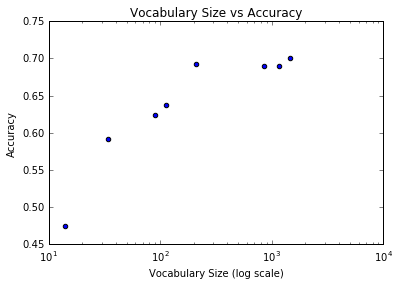

In [441]:
plt.title('Vocabulary Size vs Accuracy')
plt.xlabel('Vocabulary Size (log scale)')
plt.ylabel('Accuracy')
ax = plt.gca()
ax.set_xscale('log')
ax = ax.scatter(num_features, accuracies)

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [544]:
def P7():
    cv = TfidfVectorizer(stop_words='english')
    train_corpus = cv.fit_transform(train_data)
    dev_corpus = cv.transform(dev_data)

    clf = LogisticRegression(C=100)
    clf.fit(train_corpus, train_labels)
    preds = clf.predict(dev_corpus)
    
    print classification_report(dev_labels, preds, target_names=newsgroups_train.target_names)
    
P7()

                    precision    recall  f1-score   support

       alt.atheism       0.71      0.62      0.66       165
     comp.graphics       0.89      0.92      0.91       185
         sci.space       0.79      0.88      0.83       199
talk.religion.misc       0.68      0.64      0.66       127

       avg / total       0.78      0.78      0.78       676



In [550]:
# top 3 documents by R

probas = clf.predict_proba(dev_corpus)
preds = clf.predict(dev_corpus)
max_prob = np.argmax(probas, axis=1)

r_values = [probas[i,j] / probas[i,dev_labels[i]] for i, j in enumerate(max_prob)]

for doc in np.argsort(r_values)[::-1][:3]:
    print '-' * 95
    print 'Actual: ' + newsgroups_train.target_names[dev_labels[doc]] 
    print 'Predicted: ' + newsgroups_train.target_names[preds[doc]]
    print 'R: {:.2e}'.format(r_values[doc])
    print '-' * 95 + '\n'
    print dev_data[doc] + '\n'
    

-----------------------------------------------------------------------------------------------
Actual: comp.graphics
Predicted: sci.space
R: 6.44e+125
-----------------------------------------------------------------------------------------------

Invitation to the 8th SCIA

The 8th Scandinavian Conference on Image Analysis will be
arranged by the Norwegian Society for Image Processing and
Pattern Recognition (NOBIM) and sponsored by the International
Association for Pattern Recognition (IAPR). The conference
will be held in Tromsoe from 25th-28th May 1993. Tromsoe,
located at latitude 69 degrees N, is Northern Norway's centre
for administration and education.

About the Programme
The scientific programme runs over four days and includes
6 invited speakers, 29 sessions in three parallel tracks
with 127 contributed papers and 4 poster sessions with 44
contributions. The conference covers the following topics:
  - Image Processing and Analysis
  - Pattern Recognition
  - Computer Vision

ANSWER: Tfidf differs by normalizing the vector weights for each label by the frequency with which they appear in the overall corpus. This accounts for the fact that some features are more likely to appear in general. One thing that the top errors appear to have in common is that they often contain "off-topic" content and long quotes. This increases the likelihood of other content finding it way into the document. One solution to this may be to truncate the message at a certain point, and hoping that the most important identifying features appears in the start of the message.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

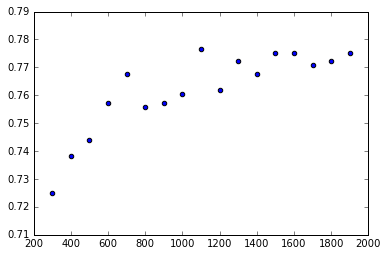

In [563]:
scores = []
message_length = range(300,2000,100)

for length in message_length:
    def truncating_preprocessor(s):
        s = s.lower()
        return s[:length]


    cv = TfidfVectorizer(stop_words='english', preprocessor=truncating_preprocessor)
    train_corpus = cv.fit_transform(train_data)
    dev_corpus = cv.transform(dev_data)

    clf = LogisticRegression(C=100)
    clf.fit(train_corpus, train_labels)
    score = clf.score(dev_corpus, dev_labels)
    scores.append(score)

plt.scatter(message_length, scores)


Unfortunately, it seems that truncating the message does not improve overall performance of the model.